# Dependencias

In [359]:
import numpy as np
import pandas as pd

from datetime import datetime

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest

from scikitplot.metrics import plot_roc

import seaborn as sns
import cufflinks as cf
import matplotlib.pyplot as plt

cf.go_offline()
pd.set_option('display.max_columns',None)

# Lectura de datos

In [360]:
ruta = '/home/oscarjarillo/Documentos/Análisis Multivariado/Perceptron/medidas amv.csv'
df = pd.read_csv(ruta)
df.head()

,Marca temporal,Edad (Años),Estatura (cm),Peso (Kg),"# de Zapato (23,24,25, 25.5, ..., etc)",Sexo
0,2022/02/15 6:31:48 p. m. GMT-6,21,163.0,65.0,24.5,Mujer
1,2022/02/15 6:31:51 p. m. GMT-6,21,180.0,70.0,28.0,Hombre
2,2022/02/15 6:31:55 p. m. GMT-6,22,180.0,80.0,28.5,Hombre
3,2022/02/15 6:31:55 p. m. GMT-6,21,180.0,83.0,29.0,Hombre
4,2022/02/15 6:31:56 p. m. GMT-6,23,178.0,67.0,27.5,Hombre


In [361]:
df.shape

(63, 6)

In [362]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63 entries, 0 to 62
Data columns (total 6 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Marca temporal                          63 non-null     object 
 1   Edad (Años)                             63 non-null     int64  
 2   Estatura (cm)                           63 non-null     float64
 3   Peso (Kg)                               63 non-null     float64
 4   # de Zapato (23,24,25, 25.5, ..., etc)  63 non-null     float64
 5   Sexo                                    63 non-null     object 
dtypes: float64(3), int64(1), object(2)
memory usage: 3.1+ KB


In [363]:
df.rename(columns={'# de Zapato (23,24,25, 25.5, ..., etc)':'# de Zapato'},inplace=True)

# Definición de variables

In [364]:
df.insert(0,'id',df.index+1)

In [365]:
um = ['id']
vart = ['Sexo']
varc = [v for v in df.columns if v not in um and v not in vart and v!='Marca temporal']

# Análisis exploratorio

## Valores nulos

In [366]:
nulos = 1-df.describe().T[['count']]/len(df)
nulos

,count
id,0.0
Edad (Años),0.0
Estatura (cm),0.0
Peso (Kg),0.0
# de Zapato,0.0


## Varianza nula

In [367]:
X = df.copy()

In [368]:
vt = VarianceThreshold()
vt.fit(X[varc])

VarianceThreshold()

In [369]:
fuera = [a for a,b in zip(varc,vt.get_support())if not b]
fuera

[]

## Selección de variables con mejor poder predictivo

In [370]:
sk = SelectKBest(k=len(varc))
sk.fit(X[varc],X[vart[0]])

SelectKBest(k=4)

In [371]:
pd.DataFrame(zip(varc,sk.scores_),columns=['var','score']).set_index('var').sort_values(by='score',
                                                        ascending=False).iplot(kind='bar',color='orange')

In [372]:
sk = SelectKBest(k=3)
sk.fit(X[varc],X[vart[0]])

SelectKBest(k=3)

In [373]:
best = [a for a,b in zip(varc,sk.get_support())if b]
best

['Estatura (cm)', 'Peso (Kg)', '# de Zapato']

## Valores extremos

array([[<AxesSubplot:title={'center':'Estatura (cm)'}>,
        <AxesSubplot:title={'center':'Peso (Kg)'}>],
       [<AxesSubplot:title={'center':'# de Zapato'}>, <AxesSubplot:>]],
      dtype=object)

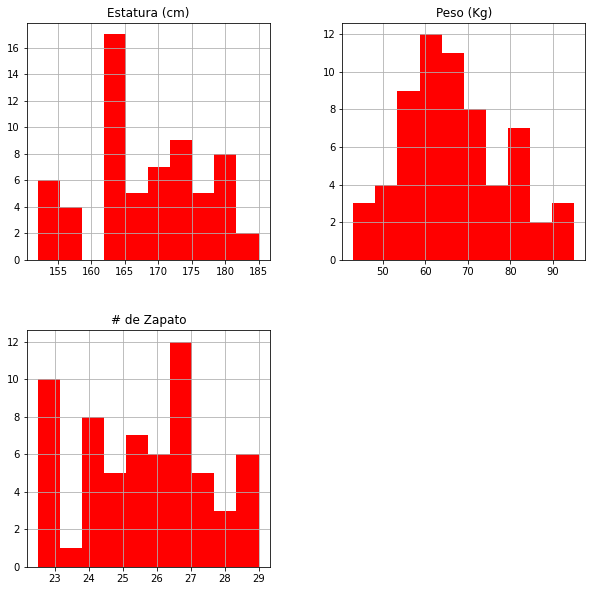

In [374]:
X[best].hist(figsize=(10,10),color='red')

In [375]:
for v,li,ls in X[best].describe(percentiles=[0.01,0.99]).T[['1%','99%']].reset_index().values:
    X[f'ex_{v}'] = ((X[v]<li)|(X[v]>ls)).astype(int)
X['ex_'] = X.filter(like='ex_').max(axis=1)
X['ex_'].value_counts(1)

0    0.952381
1    0.047619
Name: ex_, dtype: float64

In [376]:
X[um+vart] = df[um+vart]

In [377]:
X = X.loc[X['ex_']==0].drop(X.filter(like='ex_').columns,axis=1).reset_index(drop=True)

array([[<AxesSubplot:title={'center':'Estatura (cm)'}>,
        <AxesSubplot:title={'center':'Peso (Kg)'}>],
       [<AxesSubplot:title={'center':'# de Zapato'}>, <AxesSubplot:>]],
      dtype=object)

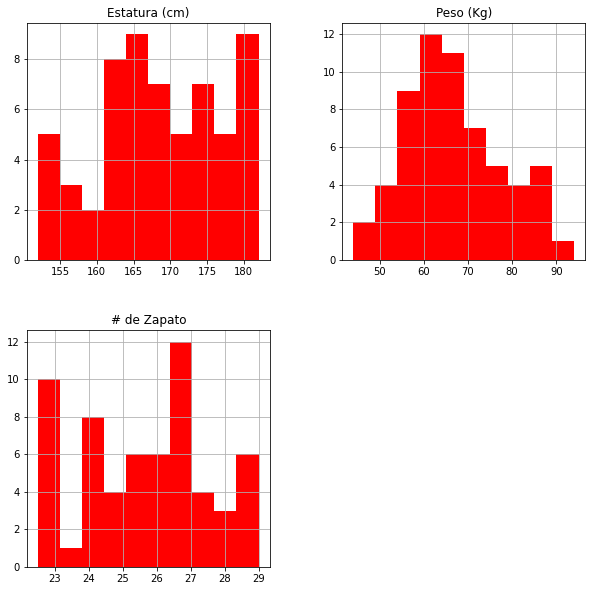

In [378]:
X[best].hist(figsize=(10,10),color='red')

## Cambio de espacio $\mathcal{X}_{[0,1]}$

In [379]:
sc = MinMaxScaler()
sc.fit(X[best],X[vart[0]])

MinMaxScaler()

In [380]:
X01 = pd.DataFrame(sc.transform(X[best]),columns=best)
X01[um+vart] = X[um+vart]

# Partición

In [381]:
Xt,Xv,yt,yv = train_test_split(X01[um+best],X01[um+vart],train_size=0.7)
Xt.reset_index(drop=True,inplace=True)
Xv.reset_index(drop=True,inplace=True)
yt.reset_index(drop=True,inplace=True)
yv.reset_index(drop=True,inplace=True)

# Aprendizaje

In [382]:
modelo = LogisticRegression()
modelo.fit(Xt[best],yt[vart[0]])

LogisticRegression()

# Validación del modelo

In [383]:
St = Xt.merge(yt,on=um,how='inner')
Sv = Xv.merge(yv,on=um,how='inner')

In [384]:
St['y^'] = modelo.predict(Xt[best])
Sv['y^'] = modelo.predict(Xv[best])

St['proba'] = modelo.predict_proba(Xt[best])[:,1]
Sv['proba'] = modelo.predict_proba(Xv[best])[:,1]

In [385]:
print(roc_auc_score(y_true=St[vart[0]],y_score=St['proba']))
print(roc_auc_score(y_true=Sv[vart[0]],y_score=Sv['proba']))

0.9435294117647058
1.0


In [386]:
print(accuracy_score(y_pred=St['y^'],y_true=St[vart[0]]))
print(accuracy_score(y_pred=Sv['y^'],y_true=Sv[vart[0]]))

0.8809523809523809
0.9444444444444444


In [387]:
print(confusion_matrix(y_pred=St['y^'],y_true=St[vart[0]]))
print(confusion_matrix(y_pred=Sv['y^'],y_true=Sv[vart[0]]))

[[24  1]
 [ 4 13]]
[[11  1]
 [ 0  6]]


<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

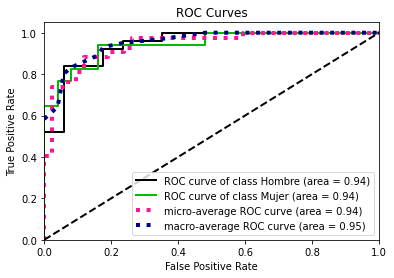

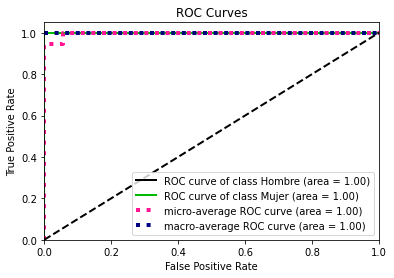

In [388]:
plot_roc(y_true=St[vart[0]],y_probas=modelo.predict_proba(St[best]))
plot_roc(y_true=Sv[vart[0]],y_probas=modelo.predict_proba(Sv[best]))